# Introduction

This model will serve as our first foray into time-series forecasting using LSTMs. We will be following [this tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).

The code will be broken into the following sections:

```{raw}
I. Data and Imports
II. Data Processing
    a. Cleaning data
    b. Separating data into drives (drive_id)
    c. Next-play feature
    d. Save Data to .h5 file
```

# I. Data and Imports

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import h5py
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [2]:
# MASK_VAL = tf.cast(-1.1, "float32")     # Does not exist in data, so will be used
MASK_VAL = 0

In [3]:
data = pd.read_csv("../../data/NFL_Play_by_Play_2009-2018_(v5).csv")

/var/folders/c7/1qq7lbrd6p50qcnbj7skxq4c0000gn/T/ipykernel_55359/1715701112.py:1: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../../data/NFL_Play_by_Play_2009-2018_(v5).csv")


In [4]:
# Exploratory feature extraction code
[col for col in data.columns.to_list() if "pos" in col or "def" in col]

['posteam',
 'posteam_type',
 'defteam',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'posteam_score',
 'defteam_score',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'def_wp',
 'home_wp_post',
 'away_wp_post',
 'pass_defense_1_player_id',
 'pass_defense_1_player_name',
 'pass_defense_2_player_id',
 'pass_defense_2_player_name',
 'defensive_two_point_attempt',
 'defensive_two_point_conv',
 'defensive_extra_point_attempt',
 'defensive_extra_point_conv']

# II. Data Processing

## II.a Data Cleaning

In [5]:
# Selecting only valid plays
data = data[data['play_type'].notna()]

In [6]:
# Dropping columns with too many missing values
data = data.dropna(axis = 1, thresh=10000)

In [7]:
# Selecting only useful columns
useful_columns = ['game_id', 'yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 
                  'game_seconds_remaining', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 
                  'ydstogo', 'ydsnet', 'yards_gained', 'shotgun', 'no_huddle', 'home_timeouts_remaining', 
                  'defteam_timeouts_remaining','defteam_score','away_timeouts_remaining', 
                  'timeout', 'defteam_timeouts_remaining', 'total_home_score',  
                  'posteam_timeouts_remaining', 'posteam_score', 'total_away_score', 'defteam_score',
                  'score_differential', 'defteam_score_post',  'score_differential_post', 'touchdown', 'play_type']
data = data[useful_columns]

In [8]:
# For LaTeX formatting
# for col in useful_columns:
#     print(r"\item " + r"\texttt{" + col.replace("_", r"\_") + "}")
#     # print(r"\item " + f"\texttt{col.replace("_", r"\_")}")

In [9]:
def classify_play_type(x):
    if x == "kickoff" or x == "punt" or x == "field_goal" or x == "extra_point":
        return 0    # Special Teams
    elif x == "pass" or x == "qb_spike":
        return 1    # pass
    elif x == "run" or x == "qb_kneel":
        return 2    # run
    else:
        return 3    # no play
    
# Classifying play type
data["play_type"] = data["play_type"].apply(classify_play_type)

In [10]:
data.head(10)

,game_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,...,total_home_score,posteam_timeouts_remaining,posteam_score,total_away_score,defteam_score,score_differential,defteam_score_post,score_differential_post,touchdown,play_type
0,2009091000,30.0,900.0,1800.0,3600.0,0,1,0,1,NaN,...,0,3.0,NaN,0,NaN,NaN,0.0,0.0,0.0,0
1,2009091000,58.0,893.0,1793.0,3593.0,0,1,0,1,1.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1
2,2009091000,53.0,856.0,1756.0,3556.0,0,1,0,1,2.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2
3,2009091000,56.0,815.0,1715.0,3515.0,0,1,0,1,3.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1
4,2009091000,56.0,807.0,1707.0,3507.0,0,1,0,1,4.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
5,2009091000,98.0,796.0,1696.0,3496.0,0,2,0,1,1.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2
6,2009091000,98.0,760.0,1660.0,3460.0,0,2,0,1,2.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1
7,2009091000,94.0,731.0,1631.0,3431.0,0,2,0,1,3.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2
8,2009091000,96.0,694.0,1594.0,3394.0,0,2,0,1,4.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
9,2009091000,43.0,684.0,1584.0,3384.0,0,3,0,1,1.0,...,0,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
# Checking missing values
data.isna().sum()

game_id                           0
yardline_100                    368
quarter_seconds_remaining         1
half_seconds_remaining           25
game_seconds_remaining           23
quarter_end                       0
drive                             0
sp                                0
qtr                               0
down                          55563
goal_to_go                        5
ydstogo                           0
ydsnet                            0
yards_gained                    213
shotgun                           0
no_huddle                         0
home_timeouts_remaining           0
defteam_timeouts_remaining        5
defteam_score                  2545
away_timeouts_remaining           0
timeout                           0
defteam_timeouts_remaining        5
total_home_score                  0
posteam_timeouts_remaining        5
posteam_score                  2545
total_away_score                  0
defteam_score                  2545
score_differential          

In [12]:
# Down missing is likely due to undowned plays, such as kickoff, extra point, etc.
data = data[~data["down"].isna()]

In [13]:
# Rechecking missing values
data.isna().sum()

game_id                         0
yardline_100                    0
quarter_seconds_remaining       0
half_seconds_remaining         19
game_seconds_remaining         20
quarter_end                     0
drive                           0
sp                              0
qtr                             0
down                            0
goal_to_go                      0
ydstogo                         0
ydsnet                          0
yards_gained                  213
shotgun                         0
no_huddle                       0
home_timeouts_remaining         0
defteam_timeouts_remaining      0
defteam_score                   0
away_timeouts_remaining         0
timeout                         0
defteam_timeouts_remaining      0
total_home_score                0
posteam_timeouts_remaining      0
posteam_score                   0
total_away_score                0
defteam_score                   0
score_differential              0
defteam_score_post              0
score_differen

In [14]:
# There arent many, so dropping remaining
data = data.dropna()
data.shape

(380692, 32)

## II.b. Separating data by drive

In [15]:
# Creating a unique drive id
data["game_id_str"] = data["game_id"].astype("str")
data["drive_str"] = data["drive"].astype('str')

data["drive_id"] = data["game_id_str"].str.cat(data["drive_str"])

In [16]:
# Dropping temporary columns I created
data = data.drop(["game_id", "game_id_str", "drive_str"],axis=1)

In [17]:
# Reordering columns
col_order = ["drive_id"] + list(data.columns)[:-1]
data = data[col_order]

In [18]:
data.head()

,drive_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,...,posteam_timeouts_remaining,posteam_score,total_away_score,defteam_score,defteam_score,score_differential,defteam_score_post,score_differential_post,touchdown,play_type
1,20090910001,58.0,893.0,1793.0,3593.0,0,1,0,1,1.0,...,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,20090910001,53.0,856.0,1756.0,3556.0,0,1,0,1,2.0,...,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,20090910001,56.0,815.0,1715.0,3515.0,0,1,0,1,3.0,...,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,20090910001,56.0,807.0,1707.0,3507.0,0,1,0,1,4.0,...,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,20090910002,98.0,796.0,1696.0,3496.0,0,2,0,1,1.0,...,3.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [19]:
# Checking for a good masking value
data[data == -1.1].count().sum()

0

In [20]:
# Checking drive_ids
ids = list(data["drive_id"].unique())
ids[:5]

['20090910001', '20090910002', '20090910003', '20090910004', '20090910005']

In [21]:
# Number of drives
len(ids)

58729

In [22]:
# Checking shape
data.shape

(380692, 36)

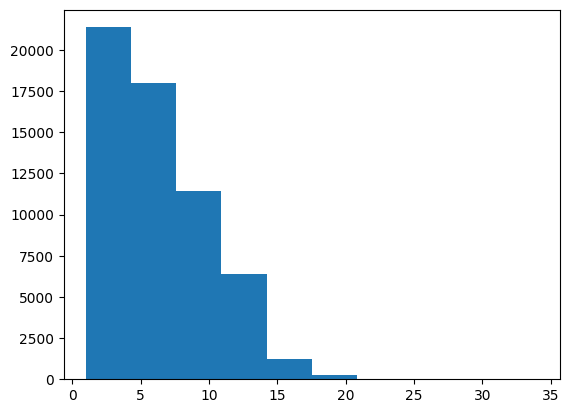

In [23]:
# Checking drive lengths

lens = []

for _, drive_frame in data.groupby("drive_id"):
    lens.append(drive_frame.shape[0])

plt.hist(lens)
plt.show()

In [24]:
max(lens)

34

In [29]:
MAX_DRIVES = 21     # There are only 54 plays with drive lengths greater than 21, so we will simply eliminate those. We will also eliminate 1 play drives since they always result in a turnover.

x = []
y = []
decoder_inputs = []


# Iterate through each drive_id
for _, drive_frame in data.groupby("drive_id"):

    # Drop the drive_id column
    drive_frame = drive_frame.drop("drive_id", axis=1).to_numpy()

    # If the number of plays in the drive is between 2 and 21
    if drive_frame.shape[0] > 1 and drive_frame.shape[0] <= MAX_DRIVES:  # Limit drives to 21 (longest drive)

        # Iteratively add chunks of the plays, so that P0, ..., P_i-1 goes to x and P_i goes to y
        # Changed start index to 2 to ensure meaningful decoder input
        for i in range(2, drive_frame.shape[0]):       
            x.append(drive_frame[:i, :])
            y.append(drive_frame[i, :])
            decoder_inputs.append(np.expand_dims(drive_frame[i-1, :], axis=0))



### II.b.i Buffer Data

In [30]:
x_padded = pad_sequences(x, maxlen=MAX_DRIVES, dtype="float32", value=MASK_VAL)
decoder_inputs = pad_sequences(decoder_inputs, maxlen=MAX_DRIVES, dtype="float32", value=MASK_VAL)

In [31]:
decoder_inputs.shape

(265129, 21, 35)

## II.d Saving Data

In [32]:
# Save data to an HDF5 file
with h5py.File('enc_dec_preprocessed_data.h5', 'w') as hf:
    hf.create_dataset('x', data=x_padded)
    hf.create_dataset('y', data=y)
    hf.create_dataset("decoder_input", data=decoder_inputs)

### Examining Data

In [ ]:
x_padded[0]

array([[ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0

In [ ]:
y[0]

array([5.600e+01, 8.150e+02, 1.715e+03, 3.515e+03, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 8.000e+00, 2.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
       0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 3.000e+00,
       0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00])

# Shapes

In [ ]:
x_padded[0].shape

(21, 35)

In [ ]:
y[0].shape

(35,)

# Old Code

In [ ]:
# WARNING: Takes 23 minutes

# Splitting the dataframe by drive ID and storing each drive as its own numpy array. 
# Each drive frame has shape (?, 35), where the question mark represents the number of plays in the drive (varies from 1-34).
# I also drop drive_id since it is non-numeric. I finally take the dataframe and insert it as a numpy array
# Thus, each element in broken_data is an array of play vectors of length 35.

# broken_data = [data[data["drive_id"] == i].drop("drive_id", axis=1).to_numpy() for i in ids]


#### II.b.i Buffering data for consistency
***Deprecated***

The longest drive was 34 plays, so we need to have each "drive" frame be of shape (34, 36)

In [ ]:
# # Renaming the list
# drive_data = broken_data

# # Initializing some values
# MAX_DRIVES = 0                      # To store the longest drive (# plays); in this data, MAX_DRIVES = 34
# FEATURES = drive_data[0].shape[1]   # To store the num of features: 35

# # Finding the longest drive
# for drive in drive_data:
#     if drive.shape[0] > MAX_DRIVES:
#         MAX_DRIVES = drive.shape[0]

# # Extending each drive frame by buffer of 0s
# for i, drive in enumerate(drive_data):
#     rows = drive.shape[0]

#     # Pad with rows of 0s
#     if rows != MAX_DRIVES:
#         buffer = np.zeros((MAX_DRIVES-rows, FEATURES))  # Create an array of 0s to fit onto the data to ensure it is of shape (MAX_DRIVES=34, 35)
#         drive_data[i] = np.concatenate((buffer, drive)) # Concatenating the 0-padding and the drive data into one numpy array and storing it

# # Setting drive data to an NP.array
# drive_data = np.array(drive_data)   


In [ ]:
# Checking that the shape is (# Drives, # Plays in each Drive, # Features) = (58729, MAX_DRIVES, FEATURES)
# drive_data.shape

In [ ]:
# Examining data. Note the 0 padding and real data at the end.
# drive_data[0]

In [ ]:
# Creating x and y data
# X data is all plays except the last play
# Y data is the last play of the drive
# TODO: Explore what this would look like if we ignored the last play of the drive (i.e. punt, FG, TD).
    # x.append(drive[:-2])
    # y.append(drive[-2])

# x = []
# y = []

# for drive in drive_data:
#     x.append(drive[:-1])
#     y.append(drive[-1])
    
# # Saving x and y lists as np.arrays
# x = np.array(x)
# y = np.array(y)

In [ ]:
# decoder_inputs.append(drive_frame[i-1, :])


#             # decoder_inputs.append(np.vstack((START_TOKEN, drive_frame[:i-1, :])))
#             # if i == 1:
#             #     decoder_inputs.append(START_TOKEN)
#             # else: 
#             #     decoder_inputs.append(drive_frame[i-1, :])

In [ ]:
# decoder_inputs = pad_sequences(decoder_inputs, maxlen=MAX_DRIVES, dtype="float32", value=MASK_VAL)
# y_padded = pad_sequences(y, maxlen=MAX_DRIVES, dtype="float32", value=MASK_VAL)

# hf.create_dataset("decoder_inputs", data=decoder_inputs)

In [ ]:
# decoder_inputs = []

# START_TOKEN = np.zeros((MAX_DRIVES, 35)) + -1.1